<a href="https://colab.research.google.com/github/98bao/Migros/blob/main/Abi_copy_Nicola_GS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DMML2020 - Project
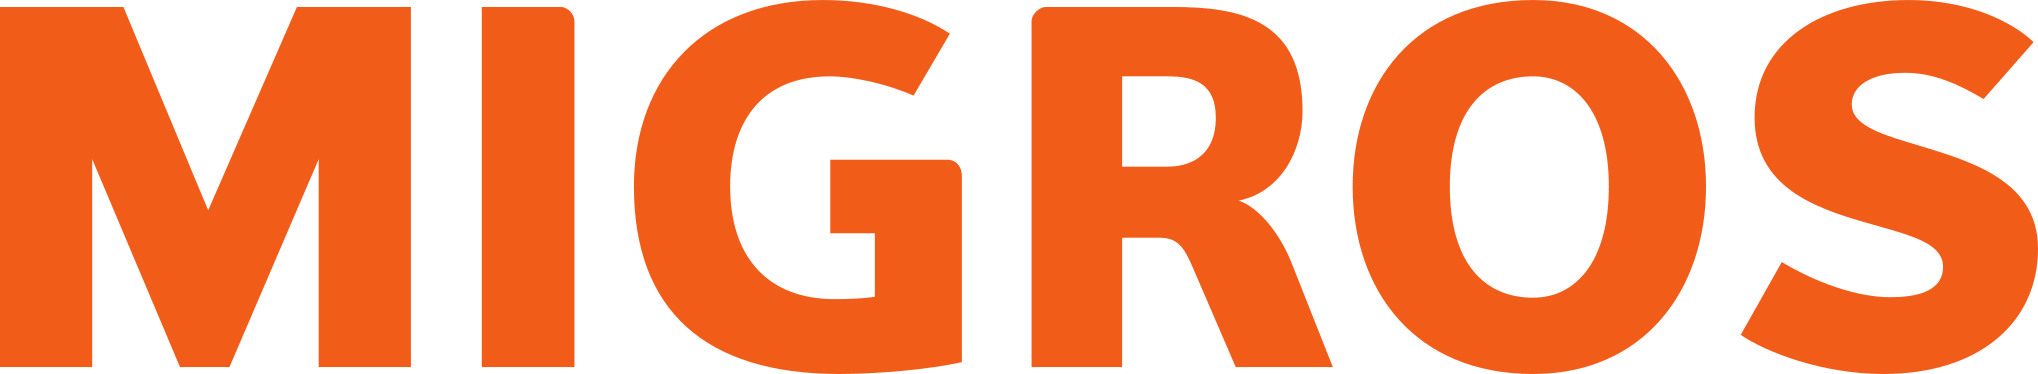
##Classification problem
In this project we analyze the data to know if a tweet is about a real disaster (target = 1) or not (target = 0).


In this first iteration we just fit the training data in the Logistic regression and observe the accuracy.

#Report 📋
  1) At first we submitted a simple logistic regression without data cleaning which gave us a satisfying accuracy of **0.805** on AICrowd
  
  2) We cleaned the text by deleting unecessary elements, then applied a logistic regression with cross validation (LRCV). Although the model built on the train data is pretty good, the accuracy on AICrowd got lower: **0.797**

  3) We used the Random Forest Classifier (RFC) and its model accuracy seemed very promising (0.97 for the train data) however, whilst submitting to AICrowd we got only a result of **0.77**. It seems like we are missing an important point as our accuracy keeps getting lower. Perhaps our model is overfitting the train data, thus we have to correct our parameters

#Importing useful tools 🧰

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
#clear output
%%capture 
# Install and update spaCy
!pip install -U spacy

!python -m spacy download en
import spacy
from spacy import displacy

In [ ]:
!pip install pyspellchecker

In [ ]:
from textblob import TextBlob


In [ ]:

import nltk
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#clear output
%%capture 

#Importing useful extensions
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

import string
from spellchecker import SpellChecker

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:
import matplotlib.pyplot as plt


#Importing the project dataframes in the notebook 📚
In the following cells, we import some raw dataframes that we are going to use for the project

In [ ]:
#Reading the dataframe to build our model
df_train = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/training_data.csv")
df_train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [ ]:
#Reading dataframe which is going to be tested
df_test = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/test_data.csv")
df_test.head(6)

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
5,10020,twister,NaN,Brain twister let drop up telly structuring ca...


In [ ]:
#Reading the sample submission
sample_submission = pd.read_csv("https://raw.githubusercontent.com/98bao/Migros/main/data/sample_submission.csv")

#Exploratory data analysis 🕵️

1.   Base rate
2.   List item



####1. Base rate
This indicate how often the most common value appears in the dataframe. We have to obtain an accuracy that is superior to the base rate to say that our classifier is well made.

In [ ]:
#Base rate of the train df
df_train['target'].value_counts() /len(df_train) 

#The base rate of this dataframe is 0.572

0    0.571936
1    0.428064
Name: target, dtype: float64

In [ ]:
#Are there null values ?
print(df_train.text.isnull().sum())
print(df_train.keyword.isnull().sum())

0
55


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


#Building the tokenizer 🤖
In the following part, we create our tokenizer which will be used to analyze the text column

In [ ]:
#Create Tokenizer

#Stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
#Punctuation
punctuations = string.punctuation

sp = spacy.load('en_core_web_sm')

#Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)

# Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]  
# Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
# Remove words with two letters or less
    mytokens = [ word for word in mytokens if len(word)>2 ]   

        
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in mytokens]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    # Return preprocessed list of tokens
    return lemma_words

#demo
review = df_train["text"].sample()
review.values[0]


'Does homeowners insurance cover water damage? Here are some good things to know. http://t.co/0uSDI5JCHo http://t.co/xyg7JhRjoF'

In [ ]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Logistic regression and pipeline

Our first iteration of the model: *No treatement of the dataframe*, just fitted in a logistic regression to see the result. We submitted this first try on AICrowd to check the accuracy of an uncleaned database.



In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7f3e197b3400>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

####Accuracy

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8935
CONFUSION MATRIX:
[[2872   89]
 [ 462 1753]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7869
CONFUSION MATRIX:
[[653  87]
 [189 366]]


####Using keywords only
This is a test to see if using only the keywords would give a good accuracy

In [ ]:
#Replace null value by an arbitrary string
df_train.keyword.fillna(value = 'nokeyword', inplace = True)

#Verify
df_train.keyword.isnull().sum()

0

In [ ]:
#Using keyword in the model
features = ['keyword', 'text']

X = df_train['keyword']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=100)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])



In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function spacy_tokenizer at 0x7f3e197b3400>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.7311
CONFUSION MATRIX:
[[2358  603]
 [ 789 1426]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7120
CONFUSION MATRIX:
[[577 163]
 [210 345]]


#Data cleaning 🧼
To further improve the accuracy of our model, we cleaned the text column by removing unecessary elements such as URL, Tags and noise.

In [ ]:
#Need to replace NaN values by blank spaces otherwise some funtions wont run  ----> is it right only on df_test ? 
df_test['text'] = df_test['text'].replace(np.nan, '')


In [ ]:

#Clean duplicates
df_train =  df_train.drop_duplicates(subset=['text'], keep='first')

#replacing "%20" with space
df_train['keyword'] = df_train['keyword'].replace('%20', ' ', regex = True)
df_train['text'] = df_train['text'].replace('%20', ' ', regex = True)
df_test['keyword'] = df_test['keyword'].replace('%20', ' ', regex = True)
df_test['text'] = df_test['text'].replace('%20', ' ', regex = True)

#removing twitter tags
def remove_tags(text):
  text = re.sub(r'@\S+','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_tags(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_tags(x))

#removing hashtags
def remove_hash(text):
  text = re.sub('#','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_hash(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_hash(x))

#removing amp
def amp(text):
  text = re.sub('&amp;', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: amp(x))
df_test['text'] = df_test['text'].apply(lambda x: amp(x))

#removing url
def remove_url(text):
  text = re.sub(r'http\S+', '', text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_url(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_url(x))



In [ ]:
#removing noises
def remove_noise(text):
  text = re.sub('RT ', '', text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_noise(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise(x))


In [ ]:

# Remove other strange characters noise
def remove_noise_1(text):
  text = re.sub('û_', '',text)
  text = re.sub('û', '', text)
  text = re.sub('&', '', text)
  text = re.sub('', '', text)
  text = re.sub('ª', '', text)
  text = re.sub('ûªs','',text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))

#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))



I did not use Following text cleaning methods (only above methods) and i obtained accuracy of 0.8177 with simple logreg.

- Removing all the numbers makes prediction worse (i have got worst result removing them using the same random_state set on train test split andd on logreg). Maybe we have to mantain dates and remove only  "strange" numbers? (if so HOOOOOW?) 
- 




In [ ]:
# Remove Stopwords
def remove_stopword(text):
  text= remove_stopwords(text)
  return text
  
df_train['text'] = df_train['text'].apply(lambda x: remove_stopword(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_stopword(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))

## Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))


In [ ]:
# remove digits
def remove_digits(text):
  text = re.sub(r"\d", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_digits(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_digits(x))

#Remove multiple spaces and spaces from Start and End 
def remove_multiple_spaces(text):
  text = re.sub(r"\s+"," ", text, flags = re.I)
  text = re.sub(r"^\s+", "", text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_multiple_spaces(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_multiple_spaces(x))

# Remove single charachters
def remove_single_characters(text):
   text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_single_characters(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_single_characters(x))

#Remove uppercase character
def remove_uppercase(text):
   text = text.lower()
   return text
df_train['text'] = df_train['text'].apply(lambda x: remove_uppercase(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_uppercase(x))

# Remove other strange characters noise
def remove_noise_1(text):
  text = re.sub('û_', '',text)
  text = re.sub('û', '', text)
  text = re.sub('&', '', text)
  text = re.sub('', '', text)
  text = re.sub('ª', '', text)
  text = re.sub('ûªs', '',text)
  return text
df_train['text'] = df_train['text'].apply(lambda x: remove_noise_1(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_noise_1(x))


#removing punctuation
def remove_punct(text):
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub(r"[0-9]+", "", text)
  return text

df_train['text'] = df_train['text'].apply(lambda x: remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_punct(x))

In [ ]:
#Spellchecking the text (it takes too much time)
#df_train.text.apply(lambda txt: ''.join(TextBlob(txt).correct()))


In [ ]:
lalo ="il campione di; calcio,  9999999 non. ri!!spetta le re??gole!!!!!! ???????????"
remove_punct(lalo)

'il campione di calcio   non rispetta le regole '

In [ ]:
#Convert dataframes to csv file to check if the rows of text looks good
df_train['text'].to_csv('df_train.csv')
df_test.to_csv('df_test.csv')


In [ ]:
# We begin by grouping text message by target 
df_train_grouped =df_train[['target','text']].groupby(by='target').agg(lambda x: ' '.join(x))
corpus = df_train_grouped['text']
print(corpus)
corpus0 = corpus[[0]]
corpus1 = corpus[[1]]
# Now we create a funcion in order to find the most common words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

target
0    black eye  space battle occurred star involvin...
1    reality training train falls elevated tracks w...
Name: text, dtype: object


In [ ]:
Whole_tweets_most_common_words = get_top_n_words(corpus, 100)
print(Whole_tweets_most_common_words)
df = pd.DataFrame(Whole_tweets_most_common_words, columns= ['Token', 'Frequency'])
Tweets_0_most_common_words = get_top_n_words(corpus0, 30)
Tweets_1_most_common_words = get_top_n_words(corpus1, 30)
print("Corpus 0 :", Tweets_0_most_common_words)
print("Corpus 1 :", Tweets_1_most_common_words)
df1 = pd.DataFrame(Tweets_1_most_common_words, columns= ['Token', 'Frequency'])
df0 = pd.DataFrame(Tweets_0_most_common_words, columns= ['Token', 'Frequency'])


[('like', 285), ('im', 262), ('new', 190), ('dont', 175), ('people', 165), ('its', 165), ('news', 161), ('video', 136), ('disaster', 131), ('emergency', 129), ('police', 112), ('time', 103), ('body', 102), ('california', 101), ('crash', 100), ('burning', 98), ('got', 98), ('man', 96), ('know', 94), ('suicide', 94), ('buildings', 93), ('storm', 93), ('day', 92), ('love', 88), ('going', 88), ('nuclear', 88), ('fires', 86), ('pm', 86), ('world', 84), ('attack', 83), ('bomb', 82), ('killed', 82), ('good', 80), ('cant', 80), ('families', 80), ('dead', 79), ('train', 76), ('today', 74), ('war', 74), ('car', 74), ('accident', 74), ('watch', 74), ('years', 73), ('hiroshima', 73), ('life', 71), ('think', 68), ('best', 66), ('work', 65), ('home', 65), ('death', 64), ('way', 64), ('wildfire', 64), ('look', 63), ('help', 63), ('right', 62), ('army', 62), ('want', 62), ('collapse', 62), ('black', 61), ('mh', 61), ('school', 60), ('forest', 58), ('need', 57), ('year', 57), ('hot', 57), ('mass', 57),

In [ ]:
def barchart_most_frequent_words(data, title):
    plt.style.use('dark_background')
    token= data['Token']
    frequency = data['Frequency']
    plt.bar(token, frequency)
    plt.title(title)
    plt.xlabel('Most frequent Words')
    plt.ylabel('Frequency')
    return plt.show()

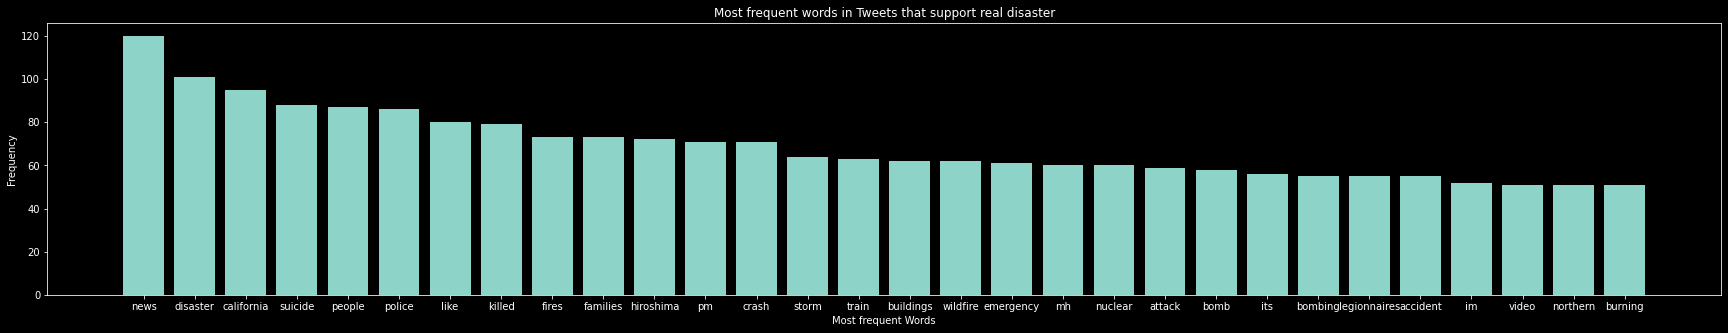

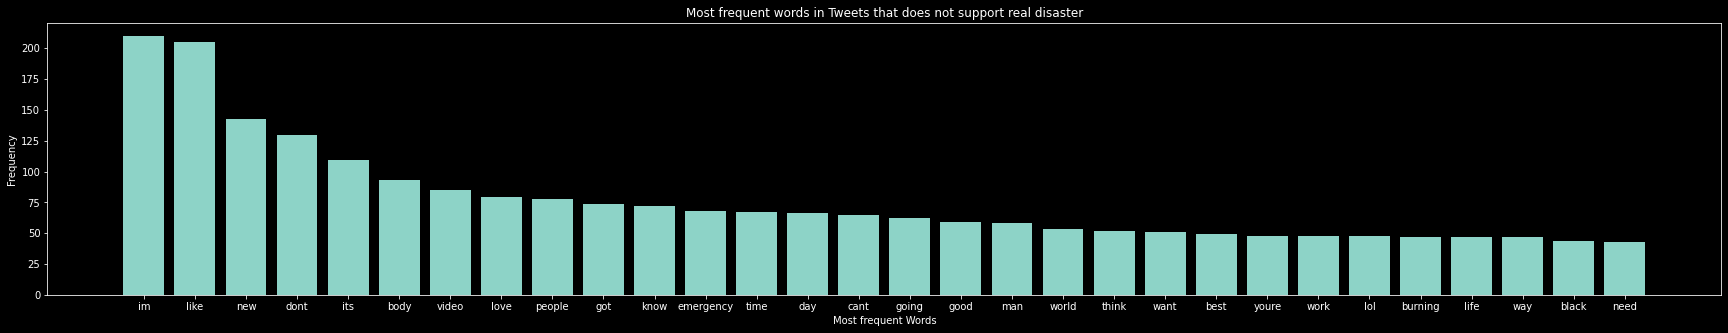

In [ ]:
plt.rcParams['figure.figsize']= (30, 5)
# Barchart Most important word 
barchart_most_frequent_words(df1, 'Most frequent words in Tweets that support real disaster')
barchart_most_frequent_words (df0, 'Most frequent words in Tweets that does not support real disaster')

#Logistic regression and pipeline after Data cleaning 

Our second iteration of the model: *treatement of the dataframe with text cleaning*, fitted in a logistic regression to see the result.



In [ ]:
#Linear reg
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

#pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

In [ ]:
#TF-IDF feature vector
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

In [ ]:
#Setting up the train test split
#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7f02fa426048>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8828
CONFUSION MATRIX:
[[2827  107]
 [ 492 1683]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7926
CONFUSION MATRIX:
[[664  78]
 [187 349]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test =pd.DataFrame(target_test)
target_test

,0
0,0
1,0
2,0
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [ ]:
sample_submission.assign(target = target_test)
target_test.to_csv('submission_0.8208-15.csv', index=False)


# Now we focalize on improving Logistic regression

In order to achieve a better result we proceed as follow: 
- optimize TF-IDF parameters
- optimize logistic regression parameters with gridSearchCV 
- Try some dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)

#Optimize the parameters of the TfidfVectorizer

In these chapter we are going to see if there are TF-IDF parameters who works better for our analysis.

In [ ]:
# Evaluate the model
def evaluate(true, pred):
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    ngram_range = [(1,1), (1,2), (1, 3), (2, 2), (2, 3), (3, 3), (3, 4)]
    min_df = [1]
    max_df = [1.0]
    analyzer=['word', 'char']
    
    # Create config instances
    for n in ngram_range:
        for i in min_df:
            for j in max_df:
              for a in analyzer:
                    cfg = [n, i, j, a]
                    models.append(cfg)
    return models

configs = configs()

In [ ]:
# Define list for result
result = []

for config in configs:

    # Redefine vectorizer
    tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=config[0],
                                   min_df=config[1], max_df=config[2], analyzer=config[3])

    # Define classifier
    LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)

    # Create pipeline
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

    # Fit model on training set
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)

    # Print accuracy on test set
    print("CONFIG: ", config)
    evaluate(y_test, y_pred)
    print("-----------------------")

    # Append to result
    result.append([config, accuracy_score(y_test, y_pred)])

CONFIG:  [(1, 1), 1, 1.0, 'word']
CONFUSION MATRIX:
[[669  73]
 [183 353]]
ACCURACY SCORE:
0.7997
CLASSIFICATION REPORT:
	Precision: 0.8286
	Recall: 0.6586
	F1_Score: 0.7339
-----------------------
CONFIG:  [(1, 1), 1, 1.0, 'char']
CONFUSION MATRIX:
[[572 170]
 [269 267]]
ACCURACY SCORE:
0.6565
CLASSIFICATION REPORT:
	Precision: 0.6110
	Recall: 0.4981
	F1_Score: 0.5488
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'word']
CONFUSION MATRIX:
[[667  75]
 [181 355]]
ACCURACY SCORE:
0.7997
CLASSIFICATION REPORT:
	Precision: 0.8256
	Recall: 0.6623
	F1_Score: 0.7350
-----------------------
CONFIG:  [(1, 2), 1, 1.0, 'char']
CONFUSION MATRIX:
[[629 113]
 [198 338]]
ACCURACY SCORE:
0.7567
CLASSIFICATION REPORT:
	Precision: 0.7494
	Recall: 0.6306
	F1_Score: 0.6849
-----------------------
CONFIG:  [(1, 3), 1, 1.0, 'word']
CONFUSION MATRIX:
[[670  72]
 [188 348]]
ACCURACY SCORE:
0.7966
CLASSIFICATION REPORT:
	Precision: 0.8286
	Recall: 0.6493
	F1_Score: 0.7280
-----------------------
CONFIG:  [

KeyboardInterrupt: ignored

### From this analysis we find out that there is some parameters that works better then the default ones specifically:
- ngram_range: (3, 4)
- min_df[1]
- max_df[1.0]
- Analyzer: 'char'


Improvement in test accurancy score from 0.7989 to 0.8099

In [ ]:
# Improved TF-IDF tokenizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

###Optimize logistic regression parameters with gridSearchCV 
The above logistic regression wwas run with the default parameters.In this chapter we are trying to improve the accurancy by tuning the hyperparameters using the "GridSearch" method. 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test

X_train_vec = tfidf_vector.fit_transform(X_train)
X_test_vec = tfidf_vector.transform(X_test)
print(X_train_vec.shape)
X_train_vec

(5109, 59159)


<5109x59159 sparse matrix of type '<class 'numpy.float64'>'
	with 761782 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_vec
print(X_test_vec.shape)

(1278, 13821)


In [ ]:
# Gridsearch Logistic regression
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

parameters = dict({'solver': ['lbfgs', 'saga'], 'C':[1, 10]})
LR =linear_model.LogisticRegression(max_iter=1000, random_state=72)

clf = GridSearchCV(
    LR, parameters, scoring='accuracy'
    )
best_model = clf.fit(X_train_vec, y_train)

In [ ]:
y_pred_test_vec= best_model.predict(X_test_vec)
y_pred_test_vec

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
#Accuracy of the train data
y_pred_train_vec = best_model.predict(X_train_vec)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train_vec):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train_vec)}")

TRAIN ACCURACY SCORE:
0.8906
CONFUSION MATRIX:
[[2852   82]
 [ 477 1698]]


In [ ]:
y_pred_test_vec = best_model.predict(X_test_vec)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test_vec):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test_vec)}")

TEST ACCURACY SCORE:
0.8106
CONFUSION MATRIX:
[[681  61]
 [181 355]]


In [ ]:
#with test data
X_S_test_vec = tfidf_vector.transform(df_test['text'])

In [ ]:
X_S_test_vec.shape

(1142, 59159)

In [ ]:
pred_X_S = best_model.predict(X_S_test_vec)
pred_X_S

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
sample_submission['target'] = pred_X_S
sample_submission.head(5)

,target
0,0
1,0
2,1
3,0
4,0


In [ ]:

sample_submission['target'].to_csv('submission-grid.csv',index=False)
from google.colab import files
files.download('submission-grid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Dimensionality reduction in order to improve accurancy and speed (Standardization and PCA)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import time

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(3, 4), min_df=1, max_df=1.0, analyzer='char')

# Fit and transform X_train and X_test
X_train_vec = tfidf_vector.fit_transform(X_train).toarray()
X_test_vec = tfidf_vector.transform(X_test).toarray()
print(X_train_vec.shape)
X_train_vec

(5109, 37466)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=5000)

# Example on X_train_vec
X_train_vec_pca = pca.fit(X_train_vec)
X_test_pca = pca.transform(X_test_vec)

print('Shape after PCA: ', X_train_vec_pca)
print('Number of components:', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  PCA(copy=True, iterated_power='auto', n_components=5000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
Number of components: 5000
Explained variance ratio:  1.0000000000000024


In [ ]:
print('Shape after PCA: ', X_train_vec_pca)
print('Number of components:', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  PCA(copy=True, iterated_power='auto', n_components=5000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
Number of components: 5000
Explained variance ratio:  1.0000000000000007


###PCA

In [ ]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

NameError: ignored

In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=5000)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

NameError: ignored

In [ ]:
# With Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time
 # Define classifier
LR = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=72)
# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegression())
                 ])

# Fit model
pipe.fit(X_train_vec, y_train)
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy:  0.9979
Test Accuracy:  0.7398


In [ ]:
# With PCA and standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LR),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

NameError: ignored

#Using different classifiers 👨‍💻

We tried different classifier to know which one could predict the best our model

##Logistic regression with cross validation

In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y )

In [ ]:
#Logistic regressin cross validation
from sklearn.linear_model import LogisticRegressionCV
LRCV = LRCV = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000, random_state=42)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LRCV)])



In [ ]:
#Fit
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function spacy_tokenizer at 0x7f8d94ff40d0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=Fal

In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.9325
CONFUSION MATRIX:
[[2868   72]
 [ 273 1896]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7926
CONFUSION MATRIX:
[[626 110]
 [155 387]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-12.csv', index=False)

##Random forest classifier 🌳🌳🌳
According to the documentation, the RFC looks like the most fitting classifier for our case. Thus we allocated a lot of ressources to improve its accuracy: in the section below there is a take on parameters tuning for RFC.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Setting up the train test split

#First for the training data
X = df_train['text']
y = df_train['target']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Define classifier
RFC = RandomForestClassifier(n_estimators = 16,max_depth = 60,random_state =42)
#Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])

In [ ]:
#Fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=60, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


In [ ]:
#Accuracy of the train data
y_pred_train = pipe.predict(X_train)
print(f"TRAIN ACCURACY SCORE:\n{accuracy_score(y_train, y_pred_train):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_pred_train)}")

TRAIN ACCURACY SCORE:
0.8325
CONFUSION MATRIX:
[[2920   14]
 [ 842 1333]]


In [ ]:
#Accuracy of the test data
y_pred_test = pipe.predict(X_test)
print(f"TEST ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")

TEST ACCURACY SCORE:
0.7567
CONFUSION MATRIX:
[[694  48]
 [263 273]]


In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
sample_submission.target = target_test
sample_submission.to_csv('submission-13.csv', index=False)

####Plot different values of parameters to find which one is optimal
####1. n_estimator

In [ ]:
#packages needed for graphs
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

In [ ]:
#Create array of values for n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

#Build function to test value of array in the model
train_results = []
test_results = []
for estimator in n_estimators:
   RFC = RandomForestClassifier(n_estimators=estimator, n_jobs=-1) 
   pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RFC)])
   pipe.fit(X_train, y_train)
   #Training data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)


NameError: ignored

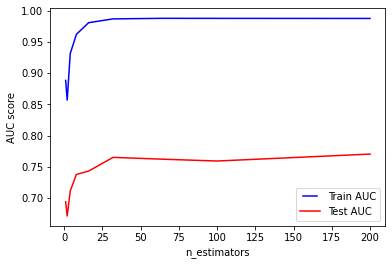

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
#We can see below a maximum for is between [25;50]

####2. max_depth

In [ ]:
#Tune max_depths parameters, analyze value between 1 and 100
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
#Creating a function
for max_depth in max_depths:
   RFC = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   
   pipe.fit(X_train, y_train)
   
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

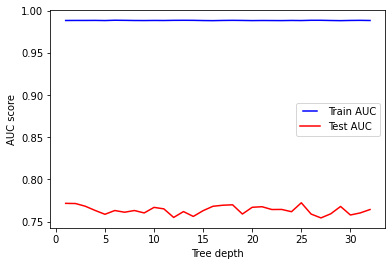

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

####3. min_samples_split

In [ ]:
#Want to know what values between 10% or 100% of the samples is needed
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
#the function
for min_samples_split in min_samples_splits:
   RFC = RandomForestClassifier(min_samples_split=min_samples_split)
   #Train data curve
   pipe.fit(X_train, y_train)
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

####4. max_features

In [ ]:
#nb of features to consider when looking for the best split
max_features = list(range(1,df_train.shape[1]))
train_results = []
test_results = []
#the function
for max_feature in max_features:
   RFC = RandomForestClassifier(max_features=max_feature)   
   pipe.fit(x_train, y_train)
   #Train data curve
   train_pred = pipe.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   #Test data curve
   y_pred = pipe.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
#Plotting the curves for train and test accuracy
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r, label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

##KNN  classifier 🌳🌳🌳
According to the documentation, the RFC looks like the most fitting classifier for our case. Thus we allocated a lot of ressources to improve its accuracy: in the section below there is a take on parameters tuning for RFC.## Grid Search

##Submission 👀
This is the code that we use to create the submission. To use it, we can just copy/paste it below the classifier of our choice and rename the .csv file.

In [ ]:
target_test = pipe.predict(df_test['text'])
target_test

In [ ]:
sample_submission.assign(target = target_test)
sample_submission.to_csv('submission-n.csv', index=False)